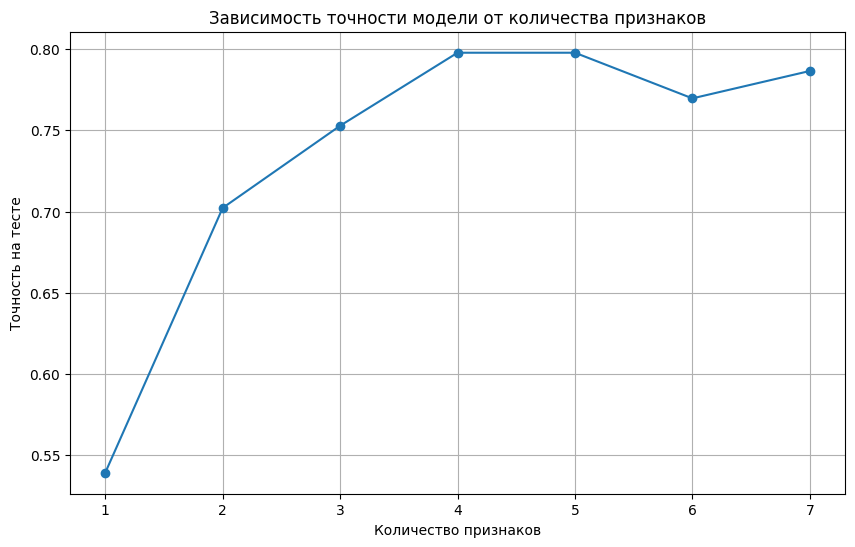

In [15]:
# 1 Исследуйте связь между количеством самых важных признаков, которые использует модель для обучения и тестовой точностью получившейся модели.
# Обучите несколько моделей с разным количеством наиболее важных признаков.
# Постройте график зависимости точности модели от количества признаков. Сделайте вывод.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Загрузка и подготовка данных Titanic
df = pd.read_csv("titanic.csv")
df = df.drop(['Unnamed: 0', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df.dropna(inplace=True)

# Исправление Pclass: строковые в числовые
df['Pclass'] = df['Pclass'].map({'first': 1, 'second': 2, 'third': 3})

# Кодируем категориальные признаки
for col in ['Sex', 'Embarked']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

X = df.drop('Survived', axis=1)
y = df['Survived']

# Делим данные
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Обучаем модель с использованием всех признаков
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Получаем важности признаков
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

accuracies = []

# Обучаем модели с разным количеством важнейших признаков
for n in range(1, len(importances)+1):
    selected_features = importances.index[:n]
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train[selected_features], y_train)
    acc = model.score(X_test[selected_features], y_test)
    accuracies.append(acc)

# Визуализация
plt.figure(figsize=(10,6))
plt.plot(range(1, len(importances)+1), accuracies, marker='o')
plt.title('Зависимость точности модели от количества признаков')
plt.xlabel('Количество признаков')
plt.ylabel('Точность на тесте')
plt.grid(True)
plt.show()


In [16]:
# 2 Используйте другие методы отбора признаков
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, RFE, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

df = pd.read_csv("titanic.csv")
df = df.drop(['Unnamed: 0', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df.dropna(inplace=True)
df['Pclass'] = df['Pclass'].map({'first': 1, 'second': 2, 'third': 3})

for col in ['Sex', 'Embarked']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

X = df.drop('Survived', axis=1)
y = df['Survived']

# 2.1) Исключение низкодисперсных признаков
selector_var = VarianceThreshold(threshold=0.01)
X_var = selector_var.fit_transform(X)
print("Оставшиеся признаки после VarianceThreshold:", X.columns[selector_var.get_support()])

# 2.2) Исключение по статистическим критериям: пример chi2 (требует неотрицательных признаков)
# Чтобы применить chi2, стандартизируем и убедимся что данные неотрицательны
X_chi = X.copy()
X_chi['Age'] = X_chi['Age'].fillna(X_chi['Age'].median())
X_chi['Fare'] = X_chi['Fare'].fillna(X_chi['Fare'].median())

# Отбираем k лучших признаков по chi2
k = 5
selector_chi = SelectKBest(score_func=chi2, k=k)
X_chi_new = selector_chi.fit_transform(X_chi, y)
print("Лучшие признаки по chi2:", X_chi.columns[selector_chi.get_support()])

# 2.3) Рекурсивное исключение признаков (RFE)
model = LogisticRegression(max_iter=500)
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X, y)
print("Лучшие признаки по RFE:", X.columns[rfe.support_])

# 2.4) Последовательное включение признаков (SFS)
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(model, n_features_to_select=5, direction='forward')
sfs.fit(X, y)
print("Лучшие признаки по SFS:", X.columns[sfs.get_support()])

# 2.5) Исключение по L1-норме (регуляризация L1)
from sklearn.linear_model import LogisticRegression

model_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=500)
model_l1.fit(X, y)
coef = pd.Series(model_l1.coef_[0], index=X.columns)
print("Коэффициенты L1-регрессии:\n", coef)
print("Отобранные признаки (не нулевые коэффициенты):", coef[coef!=0].index.tolist())


Оставшиеся признаки после VarianceThreshold: Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')
Лучшие признаки по chi2: Index(['Pclass', 'Sex', 'Age', 'Parch', 'Fare'], dtype='object')
Лучшие признаки по RFE: Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Embarked'], dtype='object')
Лучшие признаки по SFS: Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Fare'], dtype='object')
Коэффициенты L1-регрессии:
 Pclass     -1.108757
Sex        -2.499528
Age        -0.039003
SibSp      -0.330225
Parch      -0.042674
Fare        0.002348
Embarked   -0.136113
dtype: float64
Отобранные признаки (не нулевые коэффициенты): ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [17]:
# 3 Изучите возможности библиотеки imbalanced-learn.
# Примените на данном примере возможности данной библиотеки для оверсемплинга и андерсемплинга выборки.
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Подготовка данных Titanic
df = pd.read_csv("titanic.csv")
df = df.drop(['Unnamed: 0', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df.dropna(inplace=True)
df['Pclass'] = df['Pclass'].map({'first': 1, 'second': 2, 'third': 3})

for col in ['Sex', 'Embarked']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

X = df.drop('Survived', axis=1)
y = df['Survived']

print("Исходное распределение классов:", Counter(y))

# Oversampling SMOTE
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)
print("Распределение после SMOTE:", Counter(y_sm))

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)
print("Распределение после RandomUnderSampler:", Counter(y_rus))


Исходное распределение классов: Counter({0: 424, 1: 288})
Распределение после SMOTE: Counter({0: 424, 1: 424})
Распределение после RandomUnderSampler: Counter({0: 288, 1: 288})


In [18]:
# Исследуйте влияние дискретизации целевой переменной на качество модели.
# Используйте уже продемострированный подход - построение базовой модели (baseline) и сравнение модели после обработки данных с базовой.
# Проверьте разное количество категорий, а также разные стратегии группировки.
# Сделайте выводы. Обратите внимание, что после биннинга целевой переменной она стала категориальной.
# А значит, задача превратилась в задачу классификации.
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

df_cs = pd.read_csv("Customer_support_data.csv")
df_cs.dropna(subset=['CSAT Score'], inplace=True)

# Предобработка признаков — для примера используем только числовые признаки
num_cols = df_cs.select_dtypes(include=['float64', 'int64']).columns.drop('CSAT Score')
X = df_cs[num_cols]
y_cont = df_cs['CSAT Score']

# Базовая модель регрессии (предсказание числового CSAT Score)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_cont, y_test_cont = train_test_split(X, y_cont, random_state=42)

from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train, y_train_cont)
y_pred_cont = reg.predict(X_test)

# Пример метрики для регрессии
from sklearn.metrics import mean_squared_error
print("MSE базовой регрессии:", mean_squared_error(y_test_cont, y_pred_cont))

# Дискретизация: биннинг CSAT Score на 2 категории
bins = 2
y_binned = pd.cut(y_cont, bins=bins, labels=False)

# Делим на обучающую и тестовую с биннингом
_, _, y_train_bin, y_test_bin = train_test_split(X, y_binned, random_state=42)

# Классификация с бинами
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train_bin)
y_pred_bin = clf.predict(X_test)
print(f"Точность классификации с {bins} категориями:", accuracy_score(y_test_bin, y_pred_bin))

# Можно повторить с разным количеством категорий и стратегиями binning (равномерное, квантильное)
bins_list = [2, 3, 4, 5]
for b in bins_list:
    y_binned = pd.cut(y_cont, bins=b, labels=False)
    _, _, y_train_bin, y_test_bin = train_test_split(X, y_binned, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train_bin)
    y_pred_bin = clf.predict(X_test)
    print(f"Точность классификации с {b} категориями:", accuracy_score(y_test_bin, y_pred_bin))


MSE базовой регрессии: 1.925117015675707
Точность классификации с 2 категориями: 0.8204125343390604
Точность классификации с 2 категориями: 0.8204125343390604
Точность классификации с 3 категориями: 0.8205056572146948
Точность классификации с 4 категориями: 0.6852912417935466
Точность классификации с 5 категориями: 0.6851981189179122
